In [1]:
import os
import sys
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import jsonpickle as jpk
import time
import numpy as np
import pandas as pd
import torch.nn as nn
from tqdm.notebook import tqdm
# Federated imports
import forcast_federated_learning as ffl

# Parameters
num_clients        = 10
com_rounds         = 100
seed               = 0
batch_size         = 40
noise_multiplier   = 0.1
max_grad_norm      = 0.6
lr                 = 0.01
weight_decay       = 5e-5
epochs             = 1
hidden_neurons     = 500
diff_privacy       = False

# Metrics
df_metrics = pd.DataFrame(dict(zip(['round', 'rmse', 'r2_score', 'epsilon', 'delta'], [int,[],[],[],[]])))

# Load local train data
X, y, df_data, description  = ffl.datasets.load_scikit_boston()

X_mean = np.mean(X, axis=0)
X_std  = np.std(X, axis=0)
X      = (X - X_mean) / X_std

# y_mean = np.mean(y, axis=0)
# y_std  = np.std(y, axis=0)
# y      = (y - y_mean) / y_std

y_mean, y_std = 0, 1

# Split the database in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.209, random_state=seed)  

# Create custom pytorch datasers for train and testing
traindata = ffl.datasets.StructuredDataset(X_train, y_train, categorical=False)
testdata  = ffl.datasets.StructuredDataset(X_test, y_test, categorical=False)

In [2]:
# Split the train data and use only a fraction
traindata_split = ffl.data.random_split(traindata, num_clients=num_clients, seed=seed)

# Get data loader
train_loaders = [ffl.utils.DataLoader(traindata, batch_size=batch_size, shuffle=True, seed=seed)   for traindata in traindata_split]
test_loader  = ffl.utils.DataLoader(testdata, batch_size=len(testdata), shuffle=True, seed=seed)

In [3]:
# Train params
delta              = 10**-np.ceil(np.log10(len(traindata))) # delta < 1/len(dataset)
security_params    = {'noise_multiplier': noise_multiplier, 'max_grad_norm': max_grad_norm, 'batch_size': batch_size, 'sample_size': len(traindata), 'target_delta': delta} 
optimizer_params   = {'lr': lr, 'weight_decay': weight_decay}
train_params       = {'epochs': epochs}

local_models       = []
for _ in range(num_clients):
    # Create federated model based on a pytorch model
    num_features, num_outputs  = 13, 1
    model                      = ffl.models.NN_REG(input_dim=num_features, output_dim=num_outputs, hidden_dim=hidden_neurons) # pytorch model (_REG means with no softmax output)
    loss_fn                    = nn.MSELoss() # regression
    local_model                = ffl.LocalModel(model, model_type = 'nn', loss_fn=loss_fn, train_params=train_params)
    local_model.optimizer      = ffl.optim.Adam(local_model.parameters(), **optimizer_params)
    if diff_privacy == True:
        local_model.privacy_engine = ffl.security.PrivacyEngine(local_model, **security_params)
        local_model.privacy_engine.attach(local_model.optimizer)
    
    local_models.append(local_model)

In [4]:
model           = local_model.model # pytorch model
fed_model       = ffl.FederatedModel(model, model_type='nn')

In [5]:
for com_round in tqdm(range(com_rounds)):
    for local_model, train_loader in zip(local_models, train_loaders):
        local_model.step(train_loader, device='cpu')
    
    client_weights = [local_model.state_dict() for local_model in local_models]
    client_lens    = [len(traindata) for traindata in traindata_split]
    fed_model.server_agregate(client_weights, client_lens)
    weights = fed_model.state_dict()
    
    for local_model in local_models:
        local_model.load_state_dict(weights)
    
    # Test
    local_model.eval() # test mode
    output         = local_model(testdata.data)
    y_test_predict = output.detach().cpu().numpy().squeeze()
    Y_test         = testdata.targets.detach().cpu().numpy().squeeze()
    y_test_predict = (y_test_predict * y_std) + y_mean
    Y_test         = (Y_test * y_std) + y_mean
    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
    r2_test = r2_score(Y_test, y_test_predict)
    
    if (com_round % 10 == 0) or (com_round + 1 == com_rounds):
        if local_model.privacy_engine: # privacy spent
            epsilon, best_alpha = local_model.privacy_engine.get_privacy_spent(delta)
            print(f'Privacy spent: (ε = {epsilon:.2f}, δ = {delta:.2f}) - Test RMSE: {rmse_test} - Test R2: {r2_test}')
        else: 
            print(f'Test RMSE: {rmse_test} - Test R2: {r2_test}')

  0%|          | 0/100 [00:00<?, ?it/s]

Test RMSE: 22.810482025146484 - Test R2: -5.623979971196985
Test RMSE: 10.408553123474121 - Test R2: -0.3792113130286465
Test RMSE: 7.3210039138793945 - Test R2: 0.3176748488968151
Test RMSE: 7.0345587730407715 - Test R2: 0.3700242986767388
Test RMSE: 5.692572116851807 - Test R2: 0.5874589654421624
Test RMSE: 5.4104437828063965 - Test R2: 0.627337366979047
Test RMSE: 5.243279933929443 - Test R2: 0.6500095394247307
Test RMSE: 5.061090469360352 - Test R2: 0.6739093945414237
Test RMSE: 4.760944366455078 - Test R2: 0.7114398821548672
Test RMSE: 4.695668697357178 - Test R2: 0.7192983098378742
Test RMSE: 4.62470006942749 - Test R2: 0.7277190278736014


In [6]:
output         = local_model(testdata.data)
y_test_predict = output.detach().cpu().numpy().squeeze()
Y_test         = testdata.targets.detach().cpu().numpy().squeeze()
y_test_predict = (y_test_predict * y_std) + y_mean
Y_test         = (Y_test * y_std) + y_mean

The model performance for the test set
-------------------------------------------
RMSE of test set is 4.62470006942749
R2 score of test set is 0.7277190278736014


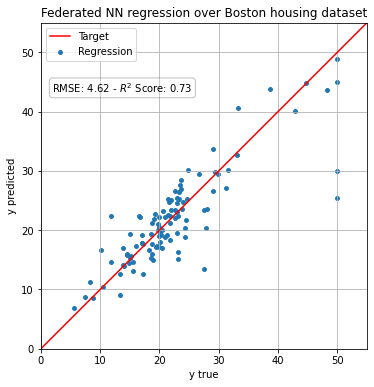

In [7]:
import matplotlib.pyplot as plt

# evaluating the model on test dataset
rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
r2_test = r2_score(Y_test, y_test_predict)

print("The model performance for the test set")
print("-------------------------------------------")
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))

# plotting the y_test vs y_pred
# ideally should have been a straight line
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(Y_test, y_test_predict, s=15, label='Regression')
ax.plot([0,55],[0,55], 'r-', label='Target')
ax.set_xlabel('y true')
ax.set_ylabel('y predicted')
ax.set_title(f'Federated NN regression over Boston housing dataset')
ax.set_xlim(xmin = 0, xmax = 55)
ax.set_ylim(ymin = 0, ymax = 55)
props = dict(boxstyle='round', facecolor='white', alpha=0.25)
ax.text(0.25, 0.8, f'RMSE: {rmse_test:.2f} - $R^2$ Score: {r2_test:.2f}', ha='center', va='center', transform=ax.transAxes, bbox=props)
ax.legend(loc='upper left')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid('on')
plt.show()